# 【项目027】基于迁移学习的蝴蝶分类（学生版） <span style="font-size:16px;"><a href="Project027TransferLearningButterfly.html?type=1&foo=5">显示答案</a> | <a href="http://deeplearning.ouxinyu.cn">返回首页</a></span>

<span style="color:blue;">作者：欧新宇（Xinyu OU）</span>
<span style="color:blue;">当前版本：Release v2.0 </span>
<span style="color:blue;">开发平台：Paddle 3.0.0-beta1</span>
<span style="color:blue;">运行环境：Intel Core i7-13700KF CPU 3.4GHz, nVidia GeForce RTX 4080</span>
<span style="color:red;">本教案所涉及的数据集仅用于教学和交流使用，请勿用作商用。</span>

**最后更新：2025年1月22日**

---

## 【实验目的】
1. 熟练掌握基于深度学习的图像分类和识别任务的基本流程
2. 能够掌握调用 `paddle.vision.models` 库实现经典内置模型(AlexNet, ResNet, VGG, MobileNet等)的基本方法，并学会使用预训练模型的调用方法
3. 理解训练集、验证集和测试集三个数据子集的区别，并掌握使用这三个数据子集的正确时机
4. 能够在模型训练过程中输出训练集上的 `准确率（Accuracy）`和 `损失值（Loss）`，以及验证集上的 `准确率` 和 `损失值`
5. 能够使用训练好的模型在测试集和验证集上输出准确率
6. 对给定的测试样本进行预测，并输出测试样本的`预测结果`及`该类别的概率`
7. 熟练掌握函数化编程方法
8. 基本学会使用 Markdwon 语法和 Jupyter Notebook 进行实验报告撰写

## 【实验要求】
1. 补全 **任务一** 到 **任务四** 的代码
2. 尽力而为地在测试集上获得最优精度，并将 **【任务五】实验结果表补充完整**，并针对 `实验结果表` 的数据给出实验结果分析
3. 完成本实验报告的撰写，并将包含运行程序结果的 `.ipynb` 文件提交到百度飞桨平台

## 【代码逻辑结构图】

深度学习的训练过程一般包括四种模式：

- **从初始状态开始训练。** 即使用随机初始化的方法对模型的参数进行初始化，并执行训练进程。
- **使用Imagenet预训练模型进行训练。** Imagenet是一个包含 130M 图像数据的数据集，使用Imagenet数据集进行预训练的模型进行迁移学习可以有效提高训练的速度和准确度，即Imagenet预训练模型能更好地对模型进行参数初始化。
- **使用自定义预训练模型进行训练。** 对于一些特殊的数据集，我们可以使用较大的自定义数据集进行预训练。然后，再将训练好的模型迁移到分布相近的数据集进行微调训练。
- **从中断模型开始训练。** 在对较大、较复杂的数据进行训练的时候，有可能会因为各种原因发生训练中断的情况，此时就需要从中断状态进行恢复训练。另一方面，在使用启发式训练（loss平稳时进行手动）的过程中，也因为需要手动进行超参数的调整，而需要手动对训练过程进行中断，并在调整参数后进行恢复训练。

根据上面所介绍的四种模型训练方法，我们通常需要在训练过程中获取并保存两种不同类型的模型：

- 一种是**调优模型**：该模型保存了训练过程的所有参数和模型的细节，该模型可以用来实现二次微调和恢复训练。
- 一种是**部署模型**：该模型只保存前向传输所必须的参数，同时经过一定的剪枝操作，因此部署模型只能用来做推理预测，但文件要比调优模型要小得多。

下图给出了训练过程中保存两种不同类型模型，以及四种训练范式的逻辑结构图。

<img alt="Projcet08TrainingMethods" src="../../Images/Projects/Project027TransferLearningButterfly/Project02702TrainingMethods.png" />


## 【任务一】 数据集准备

**实验摘要**: 对于模型训练的任务，需要数据预处理，将数据整理成为适合模型训练使用的格式。蝴蝶识别数据集是一个包含有7个不同种类619个样本的数据集，不同种类的样本按照蝴蝶的类别各自放到了相应的文件夹。不同的样本具有不同的尺度，但总体都是规整的彩色图像。  

**实验目的**:   
1. 学会观察数据集的文件结构，考虑是否需要进行数据清理，包括删除无法读取的样本、处理冗长不合规范的文件命名等  
2. 能够按照训练集、验证集、训练验证集、测试集四种子集对数据集进行划分，并生成数据列表
3. 能够根据数据划分结果和样本的类别，生成包含数据集摘要信息下数据集信息文件 `dataset_info.json`
4. 能简单展示和预览数据的基本信息，包括数据量，规模，数据类型和位深度等

**实验要求**：
1. 按照 7:1:2 的比例生成训练集、验证集、测试集和训练的数据列表，并分别保存为 `train.txt`、`val.txt`、 `test.txt` 和 `trainval.txt` 文件。注意每个列表文件的第一列是图片的绝对路径，第二列是图片的类别标签，标签从0开始编号。

```python
D:\Workspace\ExpDatasets\Butterfly\Data\admiral\adm004.jpg	0
D:\Workspace\ExpDatasets\Butterfly\Data\admiral\adm005.jpg	0
D:\Workspace\ExpDatasets\Butterfly\Data\admiral\adm006.jpg	0
```

2. 生成数据集信息文件 `dataset_info.json`，包含数据集的类别数、类别名称、训练集、验证集、测试集和训练集+验证集的数据量。该文件的内容如下：

```json
{
    "dataset_name":"Butterfly",
    "num_trainval":490,
    "num_train":423,
    "num_val":67,
    "num_test":129,
    "class_dim":7,
    "label_dict":{
        "0":"admiral",
        "1":"black_swallowtail",
        "2":"machaon",
        "3":"monarch_closed",
        "4":"monarch_open",
        "5":"peacock",
        "6":"zebra"
    }
}
```


### 1.1 数据集获取

蝴蝶数据集包含7个类，619张图片。所有数据都放在Data文件夹，并按照7个类别分别存入子文件夹；但该数据集没有官方的数据分割建议，因此需要手动进行分割。数据列表生成时将按照 `7:1:2` 的比例进行分割。以下给出数据集的下载链接。

URL：https://aistudio.baidu.com/datasetdetail/71358

### 1.2 生产图像列表及类别标签

为了便于后续的训练和预测，需要将数据集划分为训练集、验证集和测试集，并生成相应的数据列表。在本例的数据集文件中，已经提供了一个为 `generate_annotation.py` 的Python脚本，用于生成数据列表。读者也可以自行编写脚本，生成数据列表。

In [1]:
# 0. 导入必要的库
import os
import json
import codecs

# Q1-1: 初始化参数
# [Your codes]
num_trainval = 0
num_train = 0
num_val = 0
num_test = 0
class_dim = 0
dataset_info = {
    'dataset_name': '',
    'num_trainval': -1,
    'num_train': -1,
    'num_val': -1,
    'num_test': -1,
    'class_dim': -1,
    'label_dict': {}
}

# 2. 定义本地运行时，所必须的数据集名称和绝对路径，注意定义内容应该和本地文件夹名称一致
dataset_name = 'Butterfly'                                      # 数据集名称
dataset_path = 'D:\\Workspace\\ExpDatasets\\'                   # 数据集的根目录
dataset_root_path = os.path.join(dataset_path, dataset_name)    # 数据集的根目录
excluded_folder = ['.DS_Store', '.ipynb_checkpoints']           # 被排除的文件夹

# Q1-3: 定义生成文件的路径
# [Your codes]
data_path = os.path.join(dataset_root_path, 'data')             # 数据的根目录
trainval_list = os.path.join(dataset_root_path, 'trainval.txt') # 训练验证集的文件列表
train_list = os.path.join(dataset_root_path, 'train.txt')       # 训练集的文件列表
val_list = os.path.join(dataset_root_path, 'val.txt')           # 验证集的文件列表
test_list = os.path.join(dataset_root_path, 'test.txt')         # 测试集的文件列表
dataset_info_list = os.path.join(dataset_root_path, 'dataset_info.json') # 数据集信息文件

# 4. 检测数据集列表是否存在，如果已经存在，考虑先进行删除。
if os.path.exists(trainval_list):
    os.remove(trainval_list)
if os.path.exists(train_list):
    os.remove(train_list)
if os.path.exists(val_list):
    os.remove(val_list)
if os.path.exists(test_list):
    os.remove(test_list)

# 1-5: 按照 7:1:2 的比例进行数据分割，将数据集划分为训练集、验证集和测试集。
# [Your codes]
class_name_list = os.listdir(data_path)
for class_name in class_name_list:
    with codecs.open(trainval_list, 'a', 'utf-8') as f_trainval:
        with codecs.open(train_list, 'a', 'utf-8') as f_train:
            with codecs.open(val_list, 'a', 'utf-8') as f_val:
                with codecs.open(test_list, 'a', 'utf-8') as f_test:
                    if class_name not in excluded_folder:
                        dataset_info['label_dict'][str(class_dim)] = class_name
                        images = os.listdir(os.path.join(data_path, class_name))
                        count = 0
                        for image in images:
                            if count % 10 == 0:  # 抽取大约10%的样本作为验证数据
                                f_val.write("{0}\t{1}\n".format(os.path.join(data_path, class_name, image), class_dim))
                                f_trainval.write("{0}\t{1}\n".format(os.path.join(data_path, class_name, image), class_dim))
                                num_val += 1
                                num_trainval += 1
                            elif count % 10 == 1 or count % 10 == 2:  # 抽取大约20%的样本作为测试数据
                                f_test.write("{0}\t{1}\n".format(os.path.join(data_path, class_name, image), class_dim))
                                num_test += 1
                            else:
                                f_train.write("{0}\t{1}\n".format(os.path.join(data_path, class_name, image), class_dim))
                                f_trainval.write("{0}\t{1}\n".format(os.path.join(data_path, class_name, image), class_dim))
                                num_train += 1
                                num_trainval += 1
                            count += 1
    class_dim += 1        

# 1-6: 将数据子集生成过程中的统计信息保存到 json 文件中，以供训练和推理时使用
# [Your codes]
dataset_info['dataset_name'] = dataset_name
dataset_info['num_trainval'] = num_trainval
dataset_info['num_train'] = num_train
dataset_info['num_val'] = num_val
dataset_info['num_test'] = num_test
dataset_info['class_dim'] = class_dim

# 7. 输出数据集信息json和统计情况
# 7.1 将保存数据集信息的字典转换保存为json格式
with codecs.open(dataset_info_list, 'w', encoding='utf-8') as f_dataset_info:
    json.dump(dataset_info, f_dataset_info, ensure_ascii=False, indent=4, separators=(',', ':')) # 格式化字典格式的参数列表
# 7.2 在屏幕上输出各个数据子集的统计信息
print("图像列表已生成, 其中训练验证集样本{}，训练集样本{}个, 验证集样本{}个, 测试集样本{}个, 共计{}个。".format(num_trainval, num_train, num_val, num_test, num_train+num_val+num_test))

图像列表已生成, 其中训练验证集样本490，训练集样本423个, 验证集样本67个, 测试集样本129个, 共计619个。


## 【任务二】 全局参数设置及数据基本处理

**实验摘要**: 蝴蝶种类识别是一个多分类问题，我们将通过卷积神经网络来完成该任务。任务二主要实现训练前的一些准备工作，包括：全局参数定义，数据集载入，数据预处理，可视化函数定义等功能。  

**实验目的**:   
1. 学会使用配置文件定义全局参数
2. 学会定义、设置和载入数据集
3. 学会在数据集定义类中，实现对输入样本的基本预处理
4. 学会定义可视化函数，可视化训练过程，同时输出可视化结果图和数据

### 2.1 导入依赖及全局参数配置

> PS：
> 1. 注意以下代码仅为参考示例，实际使用时请根据自身需求进行修改。
> 2. 路径的定义与拼接是深度学习程序设计中非常重要的部分，请同学们务必掌握。一般来说，路径的拼接可以使用`os.path.join()`函数，该函数能够自动根据操作系统来选择合适的路径分隔符。
> 3. 在实际应用中，为了确保路径的正确性，尽量使用绝对路径，避免使用相对路径。（这里的定义与网页设计不同，因为在深度学习中的路径通常都是工作路径是固定不变的，而网页设计中的路径是相对于当前网页的，因此需要使用相对路径。）
> 4. 为了便于处理各种路径和参数，我们通常会使用一个全局配置文件来实现类似的定义。本例中我们直接在代码中定义了这些参数，实际使用时，建议同学们使用配置文件（.json, .yaml）来定义这些参数。

In [2]:
# 0. 导入依赖库
import os
import cv2
import numpy as np
import codecs
import json
import time                                     # 载入time时间库,用于计算训练时间
import paddle as paddle                         # 载入PaddlePaddle基本库
import matplotlib.pyplot as plt                 # 载入matplotlib绘图库
import warnings  
warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams['font.family'] = 'sans-serif'  
plt.rcParams['font.sans-serif'] = 'SimHei,Times New Roman'   # 中文设置成宋体，除此之外的字体设置成 Times New Roman 
np.set_printoptions(precision=5, suppress=True)              # 设置numpy的精度，用于打印输出

# 1. 全局参数配置
project_name      = 'Project027TransferLearningButterfly'                       # 定义项目名称（用于存储时的标识）
dataset_name      = 'Butterfly'                                                 # 定义数据集名称
model_name        = 'alexnet'                                              # 定义模型名称
is_pretrained     = True                                                       # 是否使用预训练模型: True/False
if is_pretrained:
    model_name = model_name + '_pretrained'                                     # 如果使用预训练模型，则模型名称后添加'_pretrained'标识
saved_name = dataset_name + '_' + model_name

# Q2-1: 定义数据集列表文件及模型路径
# [Your codes]
dataset_path      = 'D:\\WorkSpace\\ExpDatasets\\'                              # 定义数据集根路径
dataset_root_path = os.path.join(dataset_path, dataset_name)                    # 定义本项目数据集路径

trainval_list = os.path.join(dataset_root_path, 'trainval.txt')                 # 定义训练验证集列表
train_list = os.path.join(dataset_root_path, 'train.txt')                       # 定义训练集列表
val_list = os.path.join(dataset_root_path, 'val.txt')                           # 定义验证集列表
test_list = os.path.join(dataset_root_path, 'test.txt')                         # 定义测试集列表

result_root_path  = 'D:\\WorkSpace\\ExpResults\\'
result_root_path  = os.path.join(result_root_path, project_name)                                           # 定义结果保存路径
final_models_path = os.path.join(result_root_path, 'final_models', 'best_model_' + saved_name)             # 定义模型的保存的路径
deployment_model_path = final_models_path
final_figures_path = os.path.join(result_root_path, 'final_figures')    # 定义可视化图的输出路径

# Q2-2: 图像基本信息和图像增广参数
# [Your codes]
image_size         = 256                     # 统一图像尺度
input_size         = [3, 227, 227]           # 输入模型的图像尺度
mean_value         = [0.485, 0.456, 0.406]   # Imagenet均值
std_value          = [0.229, 0.224, 0.225]   # Imagenet标准差
augmentation_prob  = 0.5                     # 设置数据增广的概率
rotate_angle       = 15                      # 随机旋转的角度
Hflip_prob         = 0.5                     # 随机翻转的概率
brightness         = 0.4
contrast           = 0.4
saturation         = 0.4
hue                = 0.4

# Q2-3: 训练参数定义
# [Your codes]
total_epoch        = 50       # 总迭代次数, 代码调试好后考虑Epochs_num = 50
log_interval       = 1        # 训练时显示训练日志的间隔
eval_interval      = 1        # 设置在训练过程中,每隔一定的周期进行一次测试
learning_rate      = 0.0001    # 学习率
momentum           = 0.9      # 动量（Momentum方法时使用）
batch_size         = 64       # 设置每个批次的数据大小，同时对训练提供器和测试提供器有效

### 2.2 数据集定义及数据预处理

在Paddle 2.0+ 中，对数据的获取包含两个步骤，一是创建数据集类，二是创建数据迭代读取器。

**创建数据集类。** 使用 `paddle.io` 构造数据集类。数据类能够实现从本地获取数据列表，并对样本进行数据预处理。全新的 `paddle.vision.transforms` 可以轻松的实现样本的多种预处理功能，而不用手动去写数据预处理的函数，这大简化了代码的复杂性。对于用于训练训练集（训练验证集），我们可以按照一定的比例进行数据增广，并进行标准的数据预处理；对于验证集和测试集则只需要进行标准的数据预处理即可。

**创建数据迭代读取器。** 结合 `paddle.io.DataLoader` 工具包，可以将读入的数据进行batch划分，确定是否进行随机打乱和是否丢弃最后的冗余样本。
- 一般来说，对于训练样本(包括train和trainvl)，我们需要进行随机打乱，让每次输入到网络中的样本处于不同的组合形式，防止过拟合的产生；对于验证数据和测试数据，由于每次测试都需要对所有样本进行一次完整的遍历，并计算最终的平均值，因此是否进行打乱，并不影响最终的结果。
- 由于在最终输出的loss和accuracy的平均值时，会事先进行一次批内的平均，因此如果最后一个batch的数据并不能构成完整的一批，即实际样本数量小于batch_size，会导致最终计算精度产生一定的偏差。所以，当样本数较多的时候，可以考虑在训练时丢弃最后一个batch的数据。但值得注意的是，验证集和测试集不能进行丢弃，否则会有一部分样本无法进行测试。 

#### 2.2.1 定义数据集类

在 Paddle 中可以直接使用 `paddle.io.Dataset` 类来定义数据集类，也可以继承 `paddle.io.Dataset` 类来定义数据集类。下面我们继承 `paddle.io.Dataset` 类来定义数据集类。

In [4]:
import paddle.vision.transforms as T
from paddle.io import DataLoader

# 数据集的定义
class ButterflyDataset(paddle.io.Dataset):
    def __init__(self, dataset_root_path, mode='test'):
        assert mode in ['train', 'val', 'test', 'trainval']
        self.data = []                              # 创建空列表文件，用于保存数据的路径和标签
        
        # 1. 获取数据列表，包括数据的路径和标签
        # Q2-4: 读取数据集列表文件，并将路径路径和标签进行拆分，并将序列依次保存至data序列中，其中测试集若不存在标签则复制为"-1"
        # [Your codes]
        with open(os.path.join(dataset_root_path, mode+'.txt')) as f:
            for line in f.readlines():
                # 逐行读取.txt列表文件，并获取图像的绝对路径
                info = line.strip().split('\t')  # 以制表符为分割依据
                image_path = os.path.join(dataset_root_path, info[0].strip())   # 数据的真实路径，根据实际情况进行修改
                
                if len(info) == 2: # 包含标签的数据
                    self.data.append([image_path, info[1].strip()])
                elif len(info) == 1: # 不包含标签的数据
                    self.data.append([image_path, -1])
        
        # 2. 定义数据预处理和数据增广
        # Q2-5 使用transform接口定义数据预处理和数据增广, 并将图像转换为Paddle要求的Tensor
        # [Your codes]
        if mode in ['train', 'trainval']:                # 对于train和trainval需要进行数据增广和数据规约       
            self.transforms = T.Compose([                # 传入定义好的数据处理方法，作为自定义数据集类的一个属性
                T.Resize(image_size),                    # 先将图像压缩成 [256, 256]，然后再随机裁剪为 [227, 227]
                T.RandomResizedCrop(input_size[1:3]),
                T.RandomHorizontalFlip(Hflip_prob),
                T.RandomRotation(rotate_angle),
                T.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
                T.ToTensor(),
                T.Normalize(mean=mean_value, std=std_value),
            ])
        else:  # mode in ['val', 'test']               # 对于val和test只需要进行数据规约
            self.transforms = T.Compose([
                T.Resize(input_size[1:3]),             # 直接压缩成 [227, 227]
                T.ToTensor(),
                T.Normalize(mean=mean_value, std=std_value),
            ])
    
    # 3. 根据索引获取单个样本
    # Q2-6: 对self.data变量进行拆分，划分为图像路径及标签，并按照路径进行图像载入
    def __getitem__(self, index):
        # [Your codes]
        img_path, label = self.data[index]  # 将数据进行拆分成路径和列表
        img = cv2.imread(img_path, 1)       # 使用cv2进行数据读取可以强制将的图像转化为彩色模式，其中0为灰度模式，1为彩色模式xx
        img = self.transforms(img)          # 启用数据变量
        
        label = np.array(label, dtype='int64') 

        return img, label, img_path
                
    # 4. 获取样本总数   
    def __len__(self):        
        return len(self.data)

#### 2.2.2 设置数据提供器

对于训练、验证及推理过程中所需要使用的各个数据子集，都需要预先设置数据提供器，以便在训练、验证及推理过程中，能够方便、快速地获取到各个批次的样本数据。在本例中，将分别设置训练集、验证集及测试集的数据提供器。在设置数据提供器时，首先需要使用自定义创建的数据集类进行数据子集对象的实例化，然后再利用数据子集对象来创建数据提供器。对于每个数据子集来说，提供给模型的应该是符合训练需求的数据路径列表，而不是数据本身。对于数据列表来说，通常需要设置一次需要提供给模型的样本数量，即batch_size，以及是否需要对数据进行随机打乱，即shuffle。此外，还需要设置最后一个批次的数据样本不足一个batch_size时的处理策略。一般来说，对于四个子集，我们的处理策略如下：
- 训练集：batch_size=[全局batch_size]，shuffle=True，drop_last=True
- 验证集：batch_size=[全局batch_size]，shuffle=False，drop_last=False
- 测试集：batch_size=[全局batch_size]，shuffle=False，drop_last=False
- 训练验证集：batch_size=[全局batch_size]，shuffle=True，drop_last=True

在以上设置中，所有数据子集的batch_size都是统一的，这个数量通常按照GPU所能处理能力的80~90%进行设置；为了确保训练数据能够均匀地送入模型，train和trainval必须进行打乱，而val和test则不需要，因为每次测试它们都应该被完全覆盖；类似的，对于val和test来说，必须保证所有数据都被测试，因此不能进行末尾丢弃，即drop_last=False，而对于train和trainval，如果数据量比较大，并且需要训练多个周期，那么通常可以设置成True，而训练周期不多的小数据可以设置成False，不过，总的来说对于train和trainval这个选项影响不大，但必须保证val和test没有数据被丢弃。

In [7]:
# 1. 从数据集库中获取数据
# Q2-7：实例化自定义的数据集类以获取训练集、验证集、测试集和训练验证集数据
# [Your codes]
dataset_trainval = ButterflyDataset(dataset_root_path, mode='trainval')
dataset_train = ButterflyDataset(dataset_root_path, mode='train')
dataset_val = ButterflyDataset(dataset_root_path, mode='val')
dataset_test = ButterflyDataset(dataset_root_path, mode='test')

# 2. 创建读取器
# Q2-8：根据实例化的数据子集对象，创建数据读取器，要求每个数据读取器中包含的样本数量为batch_size
# [Your codes]
trainval_reader = DataLoader(dataset_trainval, batch_size=batch_size, shuffle=True, drop_last=True)
train_reader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
val_reader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, drop_last=False)
test_reader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False)

####################################################################################################################
# 3.测试读取器，显示地i个batch中图像和标签的形状
if __name__ == "__main__":
    for i, (image, label, img_path) in enumerate(val_reader()):
        print('验证集 batch_{} 的图像形态: {}, 标签形态: {}, {}'.format(i, image.shape, label.shape, img_path))
        break

验证集 batch_0 的图像形态: [64, 3, 227, 227], 标签形态: [64], ['D:\\Workspace\\ExpDatasets\\Butterfly\\data\\admiral\\adm001.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\admiral\\adm011.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\admiral\\adm021.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\admiral\\adm031.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\admiral\\adm041.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\admiral\\adm051.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\admiral\\adm061.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\admiral\\adm071.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\admiral\\adm081.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\admiral\\adm091.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\admiral\\adm101.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\admiral\\adm111.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\black_swallowtail\\swa001.jpg', 'D:\\Workspace\\ExpDatasets\\Butterfly\\data\\black_swa

### 2.3 定义过程可视化函数

深度学习的训练是一个复杂的过程，为了更好地理解训练过程，并控制训练进程，通常需要将训练过程中的关键信息进行可视化。可视化的方法一般包括 **文本可视化** 和 **图例可视化**，在后续的训练代码中，我们将给出文本可视化的代码；本小节，我们给出一个图例可视化函数的示例代码，供同学们参考。首先，我们定义一个可视化函数 `draw_process_ch6`，该函数接收一个`可视化日志字典`，以及曲线图的保存路径 `final_figures_path` 和文件名 `figurename` 作为参数，同时，该函数海可以设置是否在控制台显示图例以及是否在图例中显示top5准确率。`可视化日志字典` 信息在训练过程中生成，主要包括训练集和验证集上的损失值、top1精度和top5精度等，其中训练集的指标根据批次迭代数进行呈现，验证集的指标根据周期迭代数进行呈现。

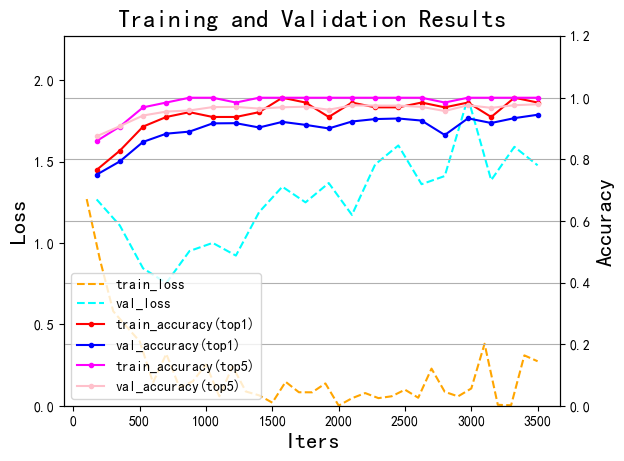

In [48]:
def draw_process_ch6(visualization_log, show_top5=True, figure_path=final_figures_path, figure_name=saved_name, isShow=True):
    """绘制训练过程中的训练误差、训练精度、验证误差和验证精度四个重要输出"""
    train_losses = visualization_log['train_losses']        # 训练集的损失值
    train_accs_top1 = visualization_log['train_accs_top1']  # 训练集的top1精确度
    train_accs_top5 = visualization_log['train_accs_top5']  # 训练集的top5精确度
    val_losses = visualization_log['val_losses']            # 验证集的损失值
    val_accs_top1 = visualization_log['val_accs_top1']      # 验证集的精确度
    val_accs_top5 = visualization_log['val_accs_top5']      # 验证集的精确度
    epoch_iters = visualization_log['epoch_iters']          # 周期epoch迭代次数
    batch_iters = visualization_log['batch_iters']          # 批次batch迭代次数

    # 第一组坐标轴 Loss
    _, ax1 = plt.subplots()
    ax1.plot(batch_iters, train_losses, color='orange', linestyle='--', label='train_loss')
    ax1.plot(epoch_iters, val_losses, color='cyan', linestyle='--', label='val_loss')
    ax1.set_xlabel('Iters', fontsize=16)
    ax1.set_ylabel('Loss', fontsize=16)
    max_loss = max(max(train_losses), max(val_losses))
    ax1.set_ylim(0, max_loss*1.2)

    # 第二组坐标轴 accuracy
    ax2 = ax1.twinx()
    ax2.plot(epoch_iters, train_accs_top1, 'o-', color='red', markersize=3, label='train_accuracy(top1)')
    ax2.plot(epoch_iters, val_accs_top1, 'o-', color='blue', markersize=3, label='val_accuracy(top1)')
    if show_top5==True:
        ax2.plot(epoch_iters, train_accs_top5, 'o-', color='magenta', markersize=3, label='train_accuracy(top5)')
        ax2.plot(epoch_iters, val_accs_top5, 'o-', color='pink', markersize=3, label='val_accuracy(top5)')
    ax2.set_ylabel('Accuracy', fontsize=16)
    max_accs = max(max(train_accs_top1), max(train_accs_top5), max(val_accs_top1), max(val_accs_top5))
    ax2.set_ylim(0, max_accs*1.2)

    # 3.配置图例
    plt.title('Training and Validation Results', fontsize=18)  
    handles1, labels1 = ax1.get_legend_handles_labels()    # 图例1
    handles2, labels2 = ax2.get_legend_handles_labels()    # 图例2
    plt.legend(handles1+handles2, labels1+labels2, loc='best')
    plt.grid()
    
    # 4.将绘图结果保存到 final_figures 目录
    plt.savefig(os.path.join(figure_path, 'training_log_' + figure_name + '.png'))
    
    # 5.显示绘图结果
    if isShow is True:
        plt.show()

### 测试可视化函数 ###################################################
if __name__ == '__main__':
    try:
        # log_file = json.loads(open(final_figures_path, '.json'), 'r', encoding='utf-8').read())
        log_file = json.loads(open('../../Images/Demo/training_log.json', 'r', encoding='utf-8').read())
        draw_process_ch6(log_file, show_top5=True)
    except:
        print('数据不存在，无法进行绘制')    

## 【任务三】 模型训练与评估

**实验摘要**: 蝴蝶种类识别是一个多分类问题，我们通过卷积神经网络来完成。这部分通过PaddlePaddle手动构造一个Alexnet卷积神经的网络来实现识别功能，最后一层采用Softmax激活函数完成分类任务。

**实验目的**:   
1. 掌握卷积神经网络的构建和基本原理 
2. 深刻理解训练集、验证集、训练验证集及测试集在模型训练中的作用
3. 学会按照网络拓扑结构图定义神经网络类 (Paddle 2.0+)
4. 学会在线测试和离线测试两种测试方法
5. 学会定义多种优化方法，并在全局参数中进行定义选择

### **3.1 配置网络模型**

在深度学习中，模型结构是非常重要的，它决定了模型的表达能力。因此，如何设计一个高性能且高效的模型结构，是深度学习领域的重要研究方向。随着深度学习的发展，越来越多的模型结构被提出，例如 Alexnet，VGG，GoogLeNet，ResNet等。这些模型结构各有特点，有的模型结构简单，有的模型结构复杂，有的模型表达能力强，有的模型表达能力弱。因此，如何选择合适的模型结构，是深度学习领域的重要问题；当然我们也可以自己去设计一些符合应用需求的模型结构。

本小节的主要工作是将设计好的模型结构呈现出来，并转换成深度学习工具包可以直接使用的形式。在这里，我们给出三种不同的形式：
- 自定义模型：手动实现将模型结构封装成类，并提供给训练和测试进程使用。
- 高阶API接口（非微调）：直接使用深度学习工具包提供的预定义模型结构。
- 高阶API接口（微调）：直接使用深度学习工具包提供的模型结构，并同时赋予预训练参数。

#### 3.1.1 自定义模型结构

自定义模型结构，需要将模型结构封装成类，自定义模型结构的好处是可以根据需求进行各个功能层的设计。本例中，我们给出 AlexNet 的实现过程，此处实现的 AlexNet 和下一小节中直接调用的结构是完全相同的。从 Alexnet 开始，包括 VGG，GoogLeNet，ResNet等模型都是层次较深的模型，如果按照逐层的方式进行设计，代码会变得非常繁琐。因此，我们可以考虑将相同结构的模型进行汇总和合成，例如 Alexnet中，`卷积层+激活+池化层` 就是一个完整的结构体。关于模型结构规划和实现的具体实现细节，可以参考 <a href="../../Html/Projects/Project008ArchitechtureDesign.html" target="_blank" alt="">【项目008】卷积神经网络的结构设计与实现</a>。

##### 3.1.1.1 AlexNet模型体系结构图

<img alt="Project00802AlexNet" src="../../Images/Projects/Project008ArchitechtureDesign/Project00802AlexNet.png" width="800px">

<span style="color:blue;">需要注意的是，在大多数深度学习工具包中，Alexnet的输入尺度会被Crop为 [3×227×227]。如果按照原始论文中 [3×224×224] 的尺度进行输入，需要适当调节网络的参数<span>

    Conv: Output_size = (Input_size - Kernel_size + 2\*Padding)/Stride + 1  
    Pool: Output_size = Input_size/Stride.

##### 3.1.1.2 网络参数配置表

|Layer|Input|Kernel_num|Kernel_size|Stride|Padding|PoolingType|Output|Parameters|
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
|Input|3×227×227|||||||
|Conv1|3×227×227|96|3×11×11|4|0||96×55×55|(3×11×11+1)×96=34944|
|Pool1|96×55×55|96|96×3×3|2|0|max|96×27×27|0|
|Conv2|96×27×27|256|96×5×5|1|2||256×27×27|(96×5×5+1)×256=614656|
|Pool2|256×27×27|256|256×3×3|2|0|max|256×13×13|0|
|Conv3|256×13×13|384|256×3×3|1|1||384×13×13|(256×3×3+1)×384=885120|
|Conv4|384×13×13|384|384×3×3|1|1||384×13×13|(384×3×3+1)×384=1327488|
|Conv5|384×13×13|256|384×3×3|1|1||256×13×13|(384×3×3+1)×256=884992|
|Pool5|256×13×13|256|256×3×3|2|0|max|256×6×6|0|
|FC6|(256×6×6)×1||||||4096×1|(9216+1)×4096=37752832|
|FC7|4096×1||||||4096×1|(4096+1)×4096=16781312|
|FC8|4096×1||||||1000×1|(4096+1)×1000=4097000|
|Output|||||||1000×1||
|||||||||Total = 62378344|

##### 3.1.1.3 模型类定义

In [73]:
import paddle
from paddle.nn import Sequential, Conv2D, MaxPool2D, Linear, Dropout, ReLU

class AlexNet(paddle.nn.Layer):
    def __init__(self, num_classes=7):
        super(AlexNet, self).__init__()
        self.num_classes = num_classes
        self.features = Sequential(
            Conv2D(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0),
            ReLU(),
            MaxPool2D(kernel_size=3, stride=2),
            Conv2D(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            ReLU(),
            MaxPool2D(kernel_size=3, stride=2),
            Conv2D(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            ReLU(),
            Conv2D(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            ReLU(),
            Conv2D(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2D(kernel_size=3, stride=2),
        )
        self.fc = Sequential(
            Linear(in_features=256*6*6, out_features=4096),
            ReLU(),
            Dropout(),
            Linear(in_features=4096, out_features=4096),
            ReLU(),
            Dropout(),
            Linear(in_features=4096, out_features=num_classes),
        )

    def forward(self, inputs):
        x = self.features(inputs)
        x = paddle.flatten(x, 1)
        x = self.fc(x)
        return x

##### 3.1.1.4 网络结构测试

使用 Paddle.summary() 方法对模型进行结构信息输出。值得注意的是，Paddle.vision.models.AlexNet 所定义的 AlexNet 模型与论文中原始的模型有细微差异，有兴趣的同学可以与 <a href="https://ouxinyu.coding.net/s/e9d2694a-9241-4e9d-bbd6-caba65a305ed" target="_blank">原论文: ImageNet Classiﬁcation with Deep Convolutional Neural Networks</a> 进行对比一下。

In [74]:
AlexNet1 = AlexNet()      # 自定义模型：AlexNet1 | 高阶API接口：AlexNet2 | 高阶API接口（预训练）： AlexNet3
paddle.summary(AlexNet1, (2, 3, 227, 227))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
  Conv2D-447     [[2, 3, 227, 227]]    [2, 96, 55, 55]        34,944     
   ReLU-133      [[2, 96, 55, 55]]     [2, 96, 55, 55]           0       
 MaxPool2D-21    [[2, 96, 55, 55]]     [2, 96, 27, 27]           0       
  Conv2D-448     [[2, 96, 27, 27]]     [2, 256, 27, 27]       614,656    
   ReLU-134      [[2, 256, 27, 27]]    [2, 256, 27, 27]          0       
 MaxPool2D-22    [[2, 256, 27, 27]]    [2, 256, 13, 13]          0       
  Conv2D-449     [[2, 256, 13, 13]]    [2, 384, 13, 13]       885,120    
   ReLU-135      [[2, 384, 13, 13]]    [2, 384, 13, 13]          0       
  Conv2D-450     [[2, 384, 13, 13]]    [2, 384, 13, 13]      1,327,488   
   ReLU-136      [[2, 384, 13, 13]]    [2, 384, 13, 13]          0       
  Conv2D-451     [[2, 384, 13, 13]]    [2, 256, 13, 13]       884,992    
   ReLU-137      [[2, 256, 13, 13]] 

{'total_params': 58310023, 'trainable_params': 58310023}

##### 3.1.1.5 网络前向传输测试

前向传输测试的过程与模型推理的过程是一致的，我们只需要将输入的图像数据传入模型即可得到输出结果。

In [75]:
print('测试前向传输:')
img = paddle.rand([2, 3, 227, 227]) 
AlexNet1 = AlexNet() 
outs = AlexNet1(img).numpy()
print(outs)
print('输出张量的形态为:{}'.format(outs.shape))

测试前向传输:
[[-0.6973   1.02828 -3.36794 -0.25918  3.78424 -3.09453  1.50276]
 [-0.89332  1.11476 -0.51523  2.15626  5.47287  0.0435   1.90901]]
输出张量的形态为:(2, 7)


#### 3.1.2 直接调用Paddle模型库中的预定义的模型

如果使用的是经典网络模型，我们可以直接从 Paddle 的模型库中进行下载，比如我们这里所使用的 `AlexNet` 模型，我们可以直接调用 Paddle.vision.models 中的 `AlexNet` 函数即可。在飞桨中，**Paddle.vision.models** 类内置了很多标准模型库，包括 LeNet, alexnet, mobilenet_v1, mobilenet_v2, resnet18(34, 50, 101, 152), vgg16, googlenet 等等，更多的模型请参考：<a href="https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/Overview_cn.html">paddle.vision</a>。

In [19]:
AlexNet2 = paddle.vision.models.alexnet(num_classes=7)   # 自定义模型：AlexNet1 | 高阶API接口：AlexNet2 | 高阶API接口（预训练）： AlexNet3
paddle.summary(AlexNet2, (2, 3, 227, 227))

----------------------------------------------------------------------------
  Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-41      [[2, 3, 227, 227]]    [2, 64, 56, 56]        23,296     
    ReLU-33       [[2, 64, 56, 56]]     [2, 64, 56, 56]           0       
  MaxPool2D-25    [[2, 64, 56, 56]]     [2, 64, 27, 27]           0       
ConvPoolLayer-19  [[2, 3, 227, 227]]    [2, 64, 27, 27]           0       
   Conv2D-42      [[2, 64, 27, 27]]     [2, 192, 27, 27]       307,392    
    ReLU-34       [[2, 192, 27, 27]]    [2, 192, 27, 27]          0       
  MaxPool2D-26    [[2, 192, 27, 27]]    [2, 192, 13, 13]          0       
ConvPoolLayer-20  [[2, 64, 27, 27]]     [2, 192, 13, 13]          0       
   Conv2D-43      [[2, 192, 13, 13]]    [2, 384, 13, 13]       663,936    
   Conv2D-44      [[2, 384, 13, 13]]    [2, 256, 13, 13]       884,992    
   Conv2D-45      [[2, 256, 13, 13]]    [2, 256, 13, 13]       590,080    
    ReLU-35       [[2, 

{'total_params': 57032519, 'trainable_params': 57032519}

#### 3.1.3 直接调用Paddle模型库的预定义模型，并启用预训练参数

飞桨模型库不仅提供了大量模型，还支持载入 Imagenet 预训练参数。在实际应用中，预训练（迁移学习）是非常有效的提高性能和缩减训练时间的方法。飞桨模型库中的预训练模型，已经针对 Imagenet 数据集进行了训练，因此可以直接使用这些预训练模型进行迁移学习，而不需要从头开始训练。

<span style="color: navy;">PS: 第一次载入预训练模型时，系统会自动下载预训练模型的参数到本地，根据网络差异可能需要2分钟左右。下载完成后会自动缓存，后续使用时直接加载，无需重复下载。</span>

In [18]:
AlexNet3 = paddle.vision.models.alexnet(num_classes=7, pretrained=True)   # 自定义模型：AlexNet1 | 高阶API接口：AlexNet2 | 高阶API接口（预训练）： AlexNet3
paddle.summary(AlexNet3, (2, 3, 227, 227))

----------------------------------------------------------------------------
  Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-36      [[2, 3, 227, 227]]    [2, 64, 56, 56]        23,296     
    ReLU-30       [[2, 64, 56, 56]]     [2, 64, 56, 56]           0       
  MaxPool2D-22    [[2, 64, 56, 56]]     [2, 64, 27, 27]           0       
ConvPoolLayer-16  [[2, 3, 227, 227]]    [2, 64, 27, 27]           0       
   Conv2D-37      [[2, 64, 27, 27]]     [2, 192, 27, 27]       307,392    
    ReLU-31       [[2, 192, 27, 27]]    [2, 192, 27, 27]          0       
  MaxPool2D-23    [[2, 192, 27, 27]]    [2, 192, 13, 13]          0       
ConvPoolLayer-17  [[2, 64, 27, 27]]     [2, 192, 13, 13]          0       
   Conv2D-38      [[2, 192, 13, 13]]    [2, 384, 13, 13]       663,936    
   Conv2D-39      [[2, 384, 13, 13]]    [2, 256, 13, 13]       884,992    
   Conv2D-40      [[2, 256, 13, 13]]    [2, 256, 13, 13]       590,080    
    ReLU-32       [[2, 

{'total_params': 57032519, 'trainable_params': 57032519}

### 3.2 定义验证函数

验证函数的功能有两个，一是在训练过程中实时对验证集进行测试（在线测试），二是在训练结束后对测试集进行测试（离线测试）。

**验证函数**的具体流程包括：
1. 初始化输出变量，包括top1精度，top5精度和损失
2. 基于批次batch的结构进行循环测试，具体包括：  
   1). 定义输入层（image，label），图像输入维度 [batch, channel, Width, Height] (-1,imgChannel,imgSize,imgSize)，标签输入维度 [batch, 1] (-1,1)  
   2). 定义输出层：在paddle2.0+中，我们使用 model.eval_batch([image],[label]) 进行评估验证，该函数可以直接输出精度和损失，但在运行前需要使用 model.prepare() 进行配置。值得注意的，在计算测试集精度的时候，需要对每个批次的精度/损失求取平均值。需要注意的是 eval_batch() 函数生成的精度和损失都是张量形态，其中 loss[0] 损失值，acc[0][0] 保存了top1精度，acc[0][1] 保存了top5精度。并且，每个批次输出的精度和损失都是独立的，且都是当前批次所有样本的平均值。
   
在定义 `eval()` 函数的时候，我们需要为其指定两个必要参数：`model` 是测试的模型，`data_reader` 是迭代的数据读取器，取值为 `val_reader()`, `test_reader()`，分别对验证集和测试集。此处验证集和测试集数据的测试过程是相同的，只是所使用的数据不同；此外，可选参数 `verbose` 用于定义是否在测试的时候输出过程。


In [100]:
from paddle.static import InputSpec

def eval(model, data_reader, verbose=0):
    acc_top1 = []
    acc_top5 = []
    losses = []
    n_total = 0

    # Q3-1：调用 model.eval_batch() 方法，定义测试迭代，只需要对验证集进行一个周期的完整推理
    # [Your codes]
    for batch_id, (image, label) in enumerate(data_reader): # 验证集|测试集
        n_batch  = len(label)
        n_total = n_total + n_batch

        # 1. 将图像转换为4D张量
        label = paddle.unsqueeze(label, axis=1)

        # 2. 使用图像和标签数据计算损失和精度
        loss, acc = model.eval_batch([image], [label])    # 调用飞桨内置的eval_batch函数，计算损失和精度
        losses.append(loss[0]*n_batch)                    # 计算当前batch的总损失
        acc_top1.append(acc[0][0]*n_batch)                # 计算当前batch的top1精度
        acc_top5.append(acc[0][1]*n_batch)                # 计算当前batch的top5精度

        # 3. 计算平均损失和精度
        avg_loss = np.sum(losses)/n_total                 # 计算截至当前batch的所有样本的平均损失
        avg_acc_top1 = np.sum(acc_top1)/n_total           # 计算截至当前batch的所有样本的平均top1精度
        avg_acc_top5 = np.sum(acc_top5)/n_total           # 计算截至当前batch的所有样本的平均top5精度
        
    return avg_loss, avg_acc_top1, avg_acc_top5

##############################################################
# 以下代码仅用于验证函数的测试，非必备。
# 测试时，需要给出定义好的模型类，训练好的模型，以及对应的数据子集
# 若数据不完整，则返回“数据不存在，跳过测试”  
if __name__ == '__main__':
    # try:
        # Q3-2：定义测试迭代，只需要对验证集进行一个周期的完整推理
        # [Your codes]
        # 1. 设置输入样本的维度，包括样本和标签   
        input_spec = InputSpec(shape=[None] + input_size, dtype='float32', name='image')
        label_spec = InputSpec(shape=[None, 1], dtype='int64', name='label')

        # 2. 载入模型，并载入训练好的模型参数
        # 注意，此处通常考虑同时输出损失值loss和top1精度、top5精度
        # network = AlexNet() 
        network = paddle.vision.models.alexnet(num_classes=7)             # 载入网络结构
        model = paddle.Model(network, input_spec, label_spec)             # 模型实例化
        model.load(final_models_path)                                     # 载入调优模型的参数
        model.prepare(loss=paddle.nn.CrossEntropyLoss(),                  # 设置loss函数
                        metrics=paddle.metric.Accuracy(topk=(1,5)))       # 设置评价指标
    
        # 3. 执行评估函数，并输出验证集样本的损失和精度
        print('开始评估...')
        avg_loss, avg_acc_top1, avg_acc_top5 = eval(model, val_reader(), verbose=1)
        print('\r [验证集] 损失: {:.5f}, top1精度:{:.5f}, top5精度为:{:.5f} \n'.format(avg_loss, avg_acc_top1, avg_acc_top5), end='')    
        avg_loss, avg_acc_top1, avg_acc_top5 = eval(model, test_reader(), verbose=1)
        print('\r [测试集] 损失: {:.5f}, top1精度:{:.5f}, top5精度为:{:.5f}'.format(avg_loss, avg_acc_top1, avg_acc_top5), end='')
    # except:
    #     print('数据不存在，跳过测试')

开始评估...
 [验证集] 损失: 0.07703, top1精度:0.98507, top5精度为:1.00000 
 [测试集] 损失: 0.08816, top1精度:0.98450, top5精度为:1.00000

### 3.4 模型训练及在线测试

在Paddle 2.0+动态图模式下，动态图模式被作为默认进程，同时动态图守护进程 `fluid.dygraph.guard(PLACE)` 被取消。

**训练部分**的具体流程包括：  
1. 定义输入层(image, label): 图像输入维度 [batch, channel, Width, Height] (-1,imgChannel,imgSize,imgSize)，标签输入维度 [batch, 1] (-1,1) 
2. 实例化网络模型: model = Alexnet()
3. 定义学习率策略和优化算法
4. 定义输出层，即模型准备函数model.prepare()
5. 基于"周期-批次"两层循环进行训练
6. 记录训练过程的结果，并定期输出模型。此处，我们可以分别保存用于调优和恢复训练的checkpoint_model模型和用于部署与预测的final_model模型（或只保存最优的模型）。

#### 3.4.1 定义训练函数

In [78]:
from paddle.static import InputSpec
import paddle.optimizer as optimizer

def train(model):
    print('启动训练...')
    start = time.perf_counter()
    num_batch = 0                 # 为便于理解迭代，手动设置批次索引ID
    best_result = 0               # 记录验证集上最好的结果
    best_result_id = 0            # 记录验证集最好结果的索引ID
    elapsed =0

    # 调用 model.train_batch() 方法，定义训练迭代。迭代过程可以有多个周期，每个周期根据batch_size划分成多个批次。
    for epoch in range(1, total_epoch+1):                            # 迭代 1~total_epoch 个周期
        for batch_id, (image, label) in enumerate(train_reader()):   # 每个周期，根据batch_size划分成多个批次
            num_batch += 1
            
            # 1. 获取训练集上的损失值和准确率
            # Q3-3. 调用model.train_batch方法进行训练，注意需要对label的尺度进行规范化
            # [Your codes] 
            label = paddle.unsqueeze(label, axis=1)                        
            loss, acc = model.train_batch([image], [label])
            
            # 2. 记录训练过程的结果，1). 打印到控制台；2). 保存到日志文件
            if num_batch % log_interval == 0: # 每隔 log_interval 个 batch显示一次日志  
                # 2.1 从推理结果中获取损失值，top1精度和top5精度
                # Q3-4. 从训练的输出中获取损失值，top1精度和top5精度
                # [Your codes] 
                avg_loss = loss[0]
                acc_top1 = acc[0][0]
                acc_top5 = acc[0][1]
                
                # 2.2 打印日志到控制台
                elapsed_step = time.perf_counter() - elapsed - start
                elapsed = time.perf_counter() - start
                print('Epoch:{}/{}, batch:{}, train_loss:[{:.5f}], acc_top1:[{:.5f}], acc_top5:[{:.5f}]({:.2f}s)'
                            .format(epoch, total_epoch, num_batch, loss[0], acc[0][0], acc[0][1], elapsed_step))

                # 2.3 记录训练过程，用于可视化训练过程中的loss和accuracy
                visualization_log['train_losses'].append(float(avg_loss))
                visualization_log['batch_iters'].append(num_batch)
                
        # 3. 每隔一定周期进行一次测试
        if epoch % eval_interval == 0 or epoch == total_epoch:
            # Q3-5: 3.1 调用自定义 eval() 函数输出验证损失和验证准确率
            # [Your codes]
            val_loss, val_acc_top1, val_acc_top5 = eval(model, val_reader())            
            print('[validation] Epoch:{}/{}, val_loss:[{:.5f}], val_top1:[{:.5f}], val_top5:[{:.5f}]'.format(epoch, total_epoch, val_loss, val_acc_top1, val_acc_top5))
            
            # 3.2 记录测试过程，用于可视化训练过程中的loss和accuracy
            visualization_log['epoch_iters'].append(num_batch)
            visualization_log['train_accs_top1'].append(float(acc_top1))
            visualization_log['train_accs_top5'].append(float(acc_top5))
            visualization_log['val_losses'].append(float(val_loss))
            visualization_log['val_accs_top1'].append(float(val_acc_top1))
            visualization_log['val_accs_top5'].append(float(val_acc_top5))

            # 3.3 如果验证准确率达到了当前最高，则保存模型
            # Q3-6: 将性能最好的模型保存为final模型，final模型的路径在全局配置中进行定义
            # 性能最优由验证集上的top1精度进行定义，即val_acc_top1
            # 注意，模型保存时，同时保存调优模型和推理模型
            # model.save(<path>, training=False|True)，True：调优模型 | False：推理模型
            # [Your codes] 
            if val_acc_top1 > best_result:
                best_result = val_acc_top1
                best_result_id = epoch

                # finetune model 用于调优和恢复训练
                model.save(final_models_path) 
                # inference model 用于部署和预测 
                model.save(final_models_path, training=False)

    # 4. 输出训练过程到控制台，并将日志字典保存为json格式，绘图数据可以在训练结束后自动显示，也可以在训练中手动执行以显示结果
    if not os.path.exists(final_figures_path):
        os.makedirs(final_figures_path)

    with codecs.open(os.path.join(final_figures_path, 'training_log_' + saved_name + '.json'), 'w', encoding='utf-8') as f_log:
        json.dump(visualization_log, f_log, ensure_ascii=False, indent=4, separators=(',', ':'))

    print('训练完成，最终性能accuracy={:.5f}(epoch={}), 总耗时{:.2f}s, 已将其保存为：best_model'.format(best_result, best_result_id, time.perf_counter() - start))

#### 3.4.2 定义训练主函数

启动训练...
Epoch:1/50, batch:1, train_loss:[1.94712], acc_top1:[0.15625], acc_top5:[0.62500](0.49s)
Epoch:1/50, batch:2, train_loss:[1.94382], acc_top1:[0.18750], acc_top5:[0.75000](0.24s)
Epoch:1/50, batch:3, train_loss:[1.94051], acc_top1:[0.20312], acc_top5:[0.84375](0.24s)
Epoch:1/50, batch:4, train_loss:[1.94506], acc_top1:[0.10938], acc_top5:[0.73438](0.23s)
Epoch:1/50, batch:5, train_loss:[1.93963], acc_top1:[0.07812], acc_top5:[0.81250](0.24s)
Epoch:1/50, batch:6, train_loss:[1.94771], acc_top1:[0.17188], acc_top5:[0.68750](0.22s)
[validation] Epoch:1/50, val_loss:[1.91711], val_top1:[0.20896], val_top5:[0.80597]
Epoch:2/50, batch:7, train_loss:[1.97089], acc_top1:[0.12500], acc_top5:[0.68750](6.83s)
Epoch:2/50, batch:8, train_loss:[1.91572], acc_top1:[0.18750], acc_top5:[0.87500](0.23s)
Epoch:2/50, batch:9, train_loss:[1.92136], acc_top1:[0.18750], acc_top5:[0.81250](0.25s)
Epoch:2/50, batch:10, train_loss:[1.90984], acc_top1:[0.21875], acc_top5:[0.89062](0.24s)
Epoch:2/50, batch

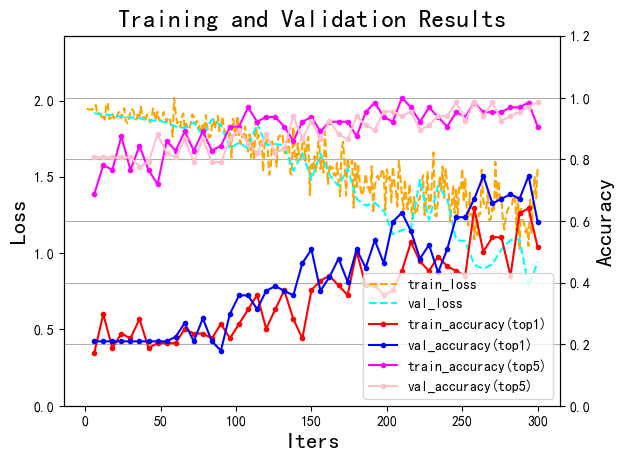

In [84]:
from paddle.static import InputSpec
#### 训练主函数 ########################################################
# 主要功能：
# 1. 初始化输入样本的维度
# 2. 初始化网络及优化器、损失函数、评估指标
# 3. 调用训练函数，训练模型，并保存最优模型
# 4. 输出训练过程和训练结果到控制台，并将日志字典保存为json格式（由训练函数完成）
# 5. 调用日志文件，绘制训练过程数据图，用于评估训练进程和训练的正确性

if __name__ == '__main__':
    visualization_log = {            # 初始化状态字典
        'train_losses': [],          # 训练损失值
        'train_accs_top1': [],       # 训练top1精度
        'train_accs_top5': [],       # 训练top5精度
        'val_losses': [],            # 验证损失值
        'val_accs_top1': [],         # 验证top1精度
        'val_accs_top5': [],         # 验证top5精度
        'batch_iters': [],           # 批次batch迭代次数
        'epoch_iters': [],           # 周期epoch迭代次数
    }
    
    # 1. 设置输入样本的维度
    # Q3-7: 使用InputSpec定义输入样本的维度，此处图像的维度为[3, 227, 227]，标签的维度为[1]
    #       同时，需要在第一个维度上设置None，表示可以接受任意数量的样本
    input_spec = InputSpec(shape=[None, 3, 227, 227], dtype='float32', name='image')
    label_spec = InputSpec(shape=[None, 1], dtype='int64', name='label')

    # 2. 载入预先定义好的网络结构，并实例化为 model 变量
    # Q3-8: 定义网络结构，此处可以调用自己设计的模型，也可以调用Paddle.models 内置的模型，并选择是否载入预训练参数
    # network = AlexNet(num_classes=7)                                                                     # 2.1 自定义模型
    network = paddle.vision.models.alexnet(num_classes=7, pretrained=is_pretrained)     # 2.2 载入Paddle内置模型并载入预训练参数，pretained=False|True 
    model = paddle.Model(network, input_spec, label_spec) 

    # 3. 设置优化方法、损失函数和评价指标
    # Q3-9: 定义优化方法，此处可用Adam|SGDMomentum优化器，并设置学习率为0.001
    Optimizer = optimizer.Adam(learning_rate=learning_rate, parameters=model.parameters()) 
    model.prepare(Optimizer,
                    paddle.nn.CrossEntropyLoss(),
                    paddle.metric.Accuracy(topk=(1,5)))

    # 4. 启动训练过程
    train(model)
    print('训练完毕，结果路径{}.'.format(result_root_path))

    # 5. 输出训练过程可视化
    draw_process_ch6(visualization_log, show_top5=True) 

**【实验结果分析】**

1. 训练完成，最终性能accuracy=0.74627(epoch=44), 总耗时179.53s, 已将其保存为：best_model_Butterfly_alexnet
2. 训练完成，最终性能accuracy=0.98507(epoch=33), 总耗时126.34s, 已将其保存为：best_model_Butterfly_alexnet_Pretrained
3. 训练完成，最终性能accuracy=0.67188(epoch=43), 总耗时100.86s, 已将其保存为：best_model_Butterfly_mobilenet_v2

上面训练**结果1**是项目Project09Alexnet中使用Alexnet模型，训练50个epoch后，在验证集上获得的精度；**结果2**同样是使用Alexnet模型进行训练获得的精度，但是使用了Imagenet预训练参数作为初始化；**结果3**是本项目中使用一个更简单的MobileNet模型，从头开始训练获得的精度。

从结果可以看到，Alexnet的模型性能要比Mobilenet更好，但在经过Imagenet预训练之后，只需要1个epoch就可以超过Alexnet训练33个epoch才能达到的精度（0.92537）；类似的，AlexNet也仅仅只需要2个epoch就可以达到0.77612的精度，更显著的是，经过6个epoch后，验证集的精度上升到0.95522。**实验结果证明说明迁移学习（Imagenet）预训练带来的性能和效率提升是显著的。** 

<span style="color:red;font-weight:blod;font-size:18px;">训练完成后，建议将 *ExpResults* 文件夹的最终文件 **copy** 到 *ExpDeployments* 用于进行部署和应用。</font>

### 3.5 离线测试

PaddlePaddle 的离线测试也抛弃了fluid方法，基本流程和训练是一致的。首先，设置样本的维度，其次初始化并载入模型，然后调用eval函数进行测试，最后输出测试结果。

仍然需要注意的是，离线测试的模型载入与训练过程中的在线测试略有不同。在模型的训练过程中，模型的参数是实时驻留在内存中的，因此可以直接调用自定义的 `eval()` 模型来进行评估；而在离线测试过程中，模型参数是存储在文件中的，因此需要预先使用 `load()` 函数来载入模型参数，才能进行评估。

In [85]:
from paddle.static import InputSpec
#### 模型测试 ########################################################
# 主要功能：
# 1. 初始化输入样本的维度
# 2. 初始化网络及优化器、损失函数、评估指标
# 3. 调用训练函数，训练模型，并保存最优模型
# 4. 输出训练过程和训练结果到控制台，并将日志字典保存为json格式（由训练函数完成）
# 5. 调用日志文件，绘制训练过程数据图，用于评估训练进程和训练的正确性

if __name__ == '__main__':
    # Q3-10: 在测试数据集上进行离线测试
    # [Your codes]
    # 1. 设置输入样本的维度    
    input_spec = InputSpec(shape=[None] + input_size, dtype='float32', name='image')
    label_spec = InputSpec(shape=[None, 1], dtype='int64', name='label')
    
    # 2. 载入模型，注意需要使用和训练时相同的模型结构
    network = paddle.vision.models.alexnet(num_classes=7)        # 载入网络结构
    model = paddle.Model(network, input_spec, label_spec)             # 模型实例化
    model.load(deployment_model_path)                                 # 载入调优模型的参数

    # 3. 设置优化方法、损失函数和评价指标
    model.prepare(loss=paddle.nn.CrossEntropyLoss(),                   # 设置loss
                metrics=paddle.metric.Accuracy(topk=(1,5)))            # 设置评价指标

    # 4. 执行评估函数，并输出测试集样本的损失和精度
    print('开始评估...')
    avg_loss, avg_acc_top1, avg_acc_top5 = eval(model, test_reader(), verbose=1)
    print('\r [测试集] 损失: {:.5f}, top1精度:{:.5f}, top5精度为:{:.5f}'.format(avg_loss, avg_acc_top1, avg_acc_top5), end='') 

开始评估...
 [测试集] 损失: 1.12645, top1精度:0.61240, top5精度为:0.96899

**【结果分析】**

需要注意的是此处的精度与训练过程中输出的测试精度是不相同的，因为训练过程中使用的必须是验证集，而这里的离线测试通常使用的是测试集。有兴趣的同学也可以测试以下验证集的精度和损失值，看看是否与训练过程中输出的精度和损失值一致。

## 【任务四】 模型推理和预测（应用）

**实验摘要**: 模型的推理和预测是指给定待测样本，通过训练好的模型，得到该样本的预测结果。对于分类任务来说，预测结果通常是一个概率分布，表示该样本属于各类别的概率。为便于理解和应用，我们通常取概率最大的类别标签作为预测结果。

**实验目的**:   
1. 学会使用部署和推理模型对待测样本进行推理
2. 学会定义推理函数，并实现批量推理和单样本推理
3. 学会对测试样本使用 `基本预处理方法` 和 `十重切割` 对样本进行预处理

### 4.1 导入依赖库及全局参数配置

PS: 正如前面所介绍的，深度学习的程序设计中，路径的定义和拼接是非常重要的，包括模型的路径、数据样本的路径、各种配置文件和第三方函数的路径等，都需要在程序一开始就进行定义和配置，以便后续使用。<span style="color:blue;font-weight:bold;">各位同学，务必熟练掌握。</font>

In [101]:
# 0.导入依赖库
import os
import cv2
import json
import random
import numpy as np
import paddle                                    # 载入PaddlePaddle基本库
import matplotlib.pyplot as plt                  # 载入python的第三方图像处理库
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"        # 解决多线程报错问题

# 1. 定义全局路径，包括项目名称、结果路径、模型路径等
# Q4-1：全局参数定义
# [Your codes]
project_name      = 'Project027TransferLearningButterfly'                       # 定义项目名称（用于存储时的标识）
dataset_name      = 'Butterfly'                                                 # 定义数据集名称
model_name        = 'alexnet_pretrained'                                              # 定义模型名称
root_path         = 'D:\\Workspace\\' 
deployment_model_path  = os.path.join(root_path, 'ExpResults', project_name, 'final_models', 'best_model_' + dataset_name + '_' + model_name)  # 定义最终模型路径
dataset_root_path = os.path.join(root_path, 'ExpDatasets', dataset_name)
json_dataset_info = os.path.join(dataset_root_path, 'dataset_info.json')

# 2. 图像基本信息
img_size = 227
img_channel = 3

### 4.2 定义推理时的预处理函数

在推理预测之前，通常需要对图像进行预处理。推理的数据预处理方法和训练时的数据预处理方法必须一致，否则会导致模型预测结果不准确；但推理的数据预处理方法可以比训练时的数据预处理方法更为简单，因为推理时不需要对图像进行增强。对于彩色图，通常只需要将图像resize为模型的输入尺度；其次需要将模型通道进行调整，转化 [C,W,H] 为 [H,W,C]，最后将像素色彩值归一化为[0,1]，这一步可以使用 `transforms.ToTensor()` 实现；最后还需要进行均值减除和方差归一。此外，按照Alexnet的建议，对于测试数据还可以进行十重切割增广以提高预测的准确率。

In [102]:
import paddle.vision.transforms as T

# 对单幅图片使用数据预处理，包括均值消除，尺度变换，通道变换和归一化
def SimplePreprocessing(image, input_size=(227,227)):
    # Q4-2：定义数据预处理函数
    # [Your codes]    
    transform = T.Compose([
        T.Resize(input_size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])

    fake_data = transform(image)
            
    return fake_data

### 4.3 数据推理

数据推理是指给定待测样本，通过训练好的模型获取该样本的预测标签。但是，由于模型推理通常只能获取到概率分布，因此我们还需要根据概率分布的最大值来确定最终的预测标签，而标签信息通常来自于数据集的信息文件中，也即 `json_dataset_info` 文件。推理过程可以定义一个函数，`predict()`，其输入为待测样本，输出为概率最大类别ID。

#### 4.3.1 定义推理和预测函数

模型推理的过程和模型训练很相似，但整个过程只需要执行一次前向传输即可，不需要计算梯度。推理过程的核心是一系列的矩阵乘法。为了获取概率分布，在输出层需要使用 `softmax` 函数来计算各个类别的归一化概率，然后再使用 `np.argmax()` 函数来获取概率最大类别ID。
PS: 由于模型的默认输入是4D张量，因此需要事先调用 `unsqueeze()` 函数将输入样本的维度从3D扩展为4D。

In [103]:
import paddle.nn.functional as F

# 对单个样本进行推理，model为训练好的模型，image为待测样本
def predict(model, image):
    # Q4-3：执行推理过程，并返回预测ID
    # [Your codes]      
    image = SimplePreprocessing(image)          # 1. 数据预处理
    image = paddle.unsqueeze(image, axis=0)     # 2. 扩展样本维度为4D张量，即增加批次
    logits = model(image)                       # 3. 模型推理，输出logits
    pred = F.softmax(logits, axis=1)            # 4. 使用softmax函数计算概率分布
    pred_id = np.argmax(pred)                   # 5. 获取概率最大类别ID

    return pred_id                              # 6. 返回预测ID

#### 4.3.2 模型推理

模型推理的过程主要包括以下几个部分：
1. 从数据集信息文件中，获取图像的标签信息字典，及类别ID所对应的标签名称
2. 获取图像文件。一般来说，我们可以直接使用一张真实的样本来进行推理，也可以从数据集中随机选择一张图像进行推理（本例）。
3. 载入训练好的模型并进行推理和预测
4. 输出推理结果

待测样本的类别为：admiral, 预测类别为：admiral


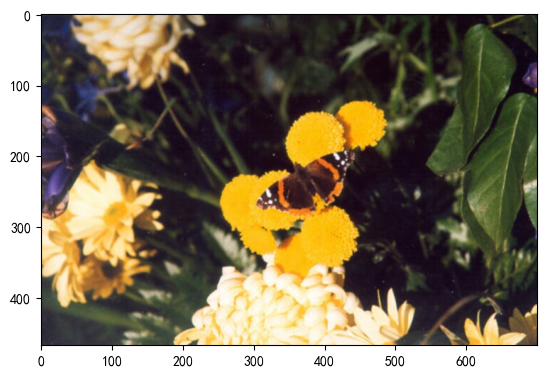

In [104]:
# Q4-4：模型推理
# [Your codes]      

# 1. 从数据集的dataset_info文件中，获取图像标签信息
with open(json_dataset_info, 'r') as f_info:
    dataset_info = json.load(f_info)

# 2. 获取图像
# 2.1 从测试列表中随机选择一个图像
test_list = os.path.join(dataset_root_path, 'test.txt')
with open(test_list, 'r') as f_test:
    lines = f_test.readlines()
line = random.choice(lines)
# 2.2 获取图像的路径和标签，其中图像用于送入模型进行预测，标签用于和预测结果进行对比
img_path, label = line.split()
img_path = os.path.join(dataset_root_path, 'Data', img_path)           
# 2.3 根据路径读取图像路径
image = cv2.imread(img_path, 1)

# 3. 使用部署模型进行预测
# 3.1 载入模型
model = paddle.jit.load(deployment_model_path)

# 3.2 调用predict方法进行预测
pred_id = predict(model, image)

# 3.3 分别根据样本的ground_turth label和预测的label 转换为label的名称
label_name_gt = dataset_info['label_dict'][str(label)]
label_name_pred = dataset_info['label_dict'][str(pred_id)]

# 4. 输出结果
# 4.1 输出预测结果
print('待测样本的类别为：{}, 预测类别为：{}'.format(label_name_gt, label_name_pred))

# 4.2 显示待预测样本
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()

## 【任务五】 结果分析


### 0. 实验要求
1. 补充完成下列ResNet18, Mobilenetv2 两个模型的结果统计表
2. 对下列结果进行总结和分析

下面我们将在ResNet18, MobilenetV2两个模型对`蝴蝶分类数据集`进行评估，所有模型设置batch_size=64。注意，以下总训练时间包括验证过程所需时间，所以实际每个批次的训练时间会小于表格中记录的时间。

### 1. 实验结果

- 模型基本配置及运行时间

|模型名称| Baseline模型 | ImageNet预训练 | learning_rate | best_epoch| 单batch时间/总训练时间(s) | 可训练参数/总参数 |
|:----:| :----: | :----: |:----:| :----: | :----: | :----: |
|Butterfly_Alexnet|Alexnet|否|0.0001|44/50|0.6s/179.53s|57,032,519/57,032,519|
|Butterfly_Alexnet_Pretrained|Alexnet|是|0.0001|33/50|0.42s/126.34s|57,032,519/57,032,519|
|Butterfly_Resnet18|ResNet18|否|0.001|48/50|0.3/89.75s|11,170,503/11,189,703|
|Butterfly_ResNet18_Pretrained|ResNet18|是|0.001|26/50|0.3/92.45s|11,170,503/11,189,703|
|Butterfly_Mobilenetv2|Mobilenetv2|否|0.001|43/50|0.3s/100.86s|2,198,727/2,266,951|
|Butterfly_Mobilenetv2_Pretrained|Mobilenetv2|是|0.001|24/50|0.3/88.07s|2,198,727/2,266,951|

- 模型性能评估结果

|模型名称| Baseline模型 | ImageNet预训练 | train_top1_acc | train_top5_acc | val_top1_acc | val_top5_acc | test_top1_acc|
|:----:| :----: | :----: |:----:| :----: | :----: | :----: | :----: |
|Butterfly_Alexnet|Alexnet|否|0.50000|0.95312|0.74627|0.94030|0.61240|
|Butterfly_Alexnet_Pretrained|Alexnet|是|0.90625|1.00000|0.98507|1.00000|0.98450|
|Butterfly_Resnet18|ResNet18|否|0.76562|0.95312|0.68657|0.92537|0.70543|
|Butterfly_ResNet18_Pretrained|ResNet18|是|0.83582|0.98507|0.95522|0.98507|0.90698|
|Butterfly_Mobilenetv2|Mobilenetv2|否|0.59375|0.98438|0.67188|0.96875|0.70149|
|Butterfly_Mobilenetv2_Pretrained|Mobilenetv2|是|0.84375|0.98438|0.93750|1.00000|0.96124|


### 2. 实验结果分析

从实验结果可以得到以下几个结论：  
1. 基于Imagenet预训练的模型在进行微调训练（finetune）时比从头训练收敛更快，且更容易获得较好的性能
2. Alexnet模型因为参数较多，且没有类似残差结构的辅助，训练难度较大，因此需要更低的学习率来进行训练
3. 参数的数量对训练时间有较大的影响
4. 从损失loss和精确度来看，没有使用Imagenet预训练参数的模型的ResNet18可能还没有完全收敛。这也证明了迁移学习在计算机视觉任务中的作用是非常明显的
5. 同一种模型的参数数量是固定的，主要由其卷积层、全连接层等内部结构决定
6. 由于任务并不复杂，因此三种模型的top5精度都比较高，说明CNN模型的判别能力还是很不错的
7. 从训练过程来看几个模型再使用预训练参数后，虽然损失loss下降速度都明显加快，但在达到一定程度后，loss反而会上升，精确度也有一定的程度的下降，这说明固定学习率上模型已经无法再进行收敛，动态学习率或者阶梯递减学习率应该能获得更稳定的收敛效果（有兴趣的同学可以进行尝试）。
8. 总体来看，几个模型的性能差距不大，这主要是因为数据集比较简单。但总体上，使用预训练模型进行微调训练（finetune）的ResNet18和MobileNet_v2更好一些，因为在相似性能下，这两个模型的参数数量远低于AlexNet，特别是MobileNet_v2d的参数只有AlexNet的1/30，因此建议在实际应用中优先考虑使用该预训练模型。

值得注意的是，由于数据集比较简单，参数的初始化以及随机梯度下降算法对于训练的过程影响比较大，并且以上实验仅使用了固定学习率。因此，每次训练的过程（甚至结果）可能会有一定的波动，但较好的超参数设置仍然有助于获得较好的性能。